In [65]:
import os
import bigfish
import bigfish.stack as stack
import bigfish.plot as plot

from aicsimageio import AICSImage
from tifffile import imsave
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from itkwidgets import view 
from aicssegmentation.core.visual import seg_fluo_side_by_side,  single_fluorescent_view, segmentation_quick_view
plt.rcParams["figure.figsize"] = [16, 12]

# dots
from aicssegmentation.core.seg_dot import dot_3d, dot_3d_wrapper 
from aicssegmentation.core.pre_processing_utils import intensity_normalization, image_smoothing_gaussian_slice_by_slice
from skimage.morphology import remove_small_objects, watershed, dilation, erosion, ball     # function for post-processing (size filter)
from skimage.feature import peak_local_max
from skimage.measure import label
from scipy.ndimage import distance_transform_edt

In [26]:
imgpath = r"\\allen\aics\assay-dev\users\Sandi\mFISH\work-080823\TOP2A-raw-080823\TOP2A_000_002.tiff"
raw = AICSImage(imgpath)
IMG = raw.get_image_data("ZYX", T=0)
IMG.shape

Failed to parse XML for the provided file. Error: not well-formed (invalid token): line 1, column 6


(51, 2048, 2048)

In [27]:
print("smfish")
print("\r min: {0}".format(IMG.min()))
print("\r max: {0}".format(IMG.max()), "\n")


smfish
 min: 150
 max: 3309 



In [28]:
rna_3d_rescaled = stack.rescale(IMG, channel_to_stretch=None)
print("smfish rescaled")
print("\r min: {0}".format(rna_3d_rescaled.min()))
print("\r max: {0}".format(rna_3d_rescaled.max()), "\n")

rna_3d_stretched = stack.rescale(IMG, channel_to_stretch=0)
print("smfish stretched")
print("\r min: {0}".format(rna_3d_stretched.min()))
print("\r max: {0}".format(rna_3d_stretched.max()))

smfish rescaled
 min: 0
 max: 65535 

smfish stretched
 min: 0
 max: 65535


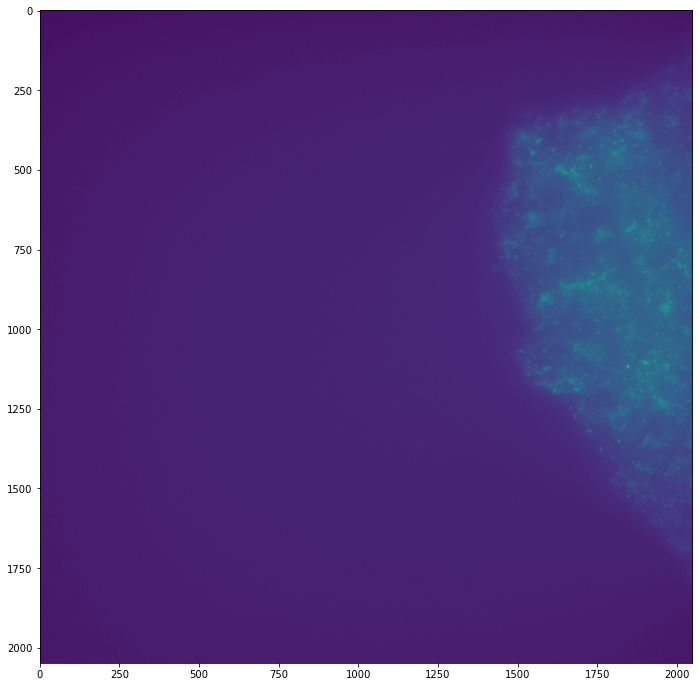

In [29]:
plt.imshow(IMG[30])

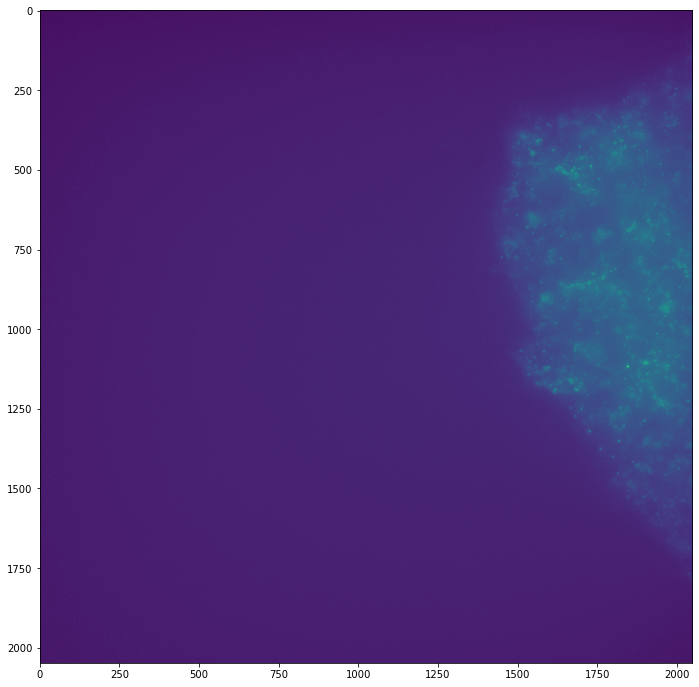

In [31]:
plt.imshow(rna_3d_rescaled[30])

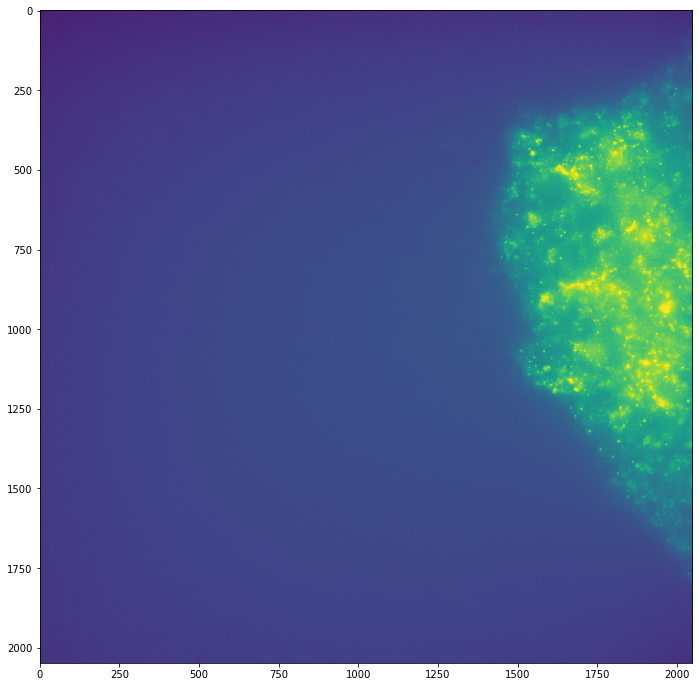

In [32]:
plt.imshow(rna_3d_stretched[30])

In [37]:
import os
import numpy as np
import bigfish
import bigfish.stack as stack
import bigfish.detection as detection
import bigfish.multistack as multistack
import bigfish.plot as plot
print("Big-FISH version: {0}".format(bigfish.__version__))

Big-FISH version: 0.6.2


In [48]:
rna_mip = stack.maximum_projection(IMG)
print("smfish channel (2D maximum projection)")
print("\r shape: {0}".format(rna_mip.shape))
print("\r dtype: {0}".format(rna_mip.dtype))

smfish channel (2D maximum projection)
 shape: (2048, 2048)
 dtype: uint16


In [49]:
spots, threshold = detection.detect_spots(
    images=IMG, 
    return_threshold=True, 
    voxel_size=(300, 103, 103),  # in nanometer (one value per dimension zyx)
    spot_radius=(350, 150, 150))  # in nanometer (one value per dimension zyx)
print("detected spots")
print("\r shape: {0}".format(spots.shape))
print("\r dtype: {0}".format(spots.dtype))
print("\r threshold: {0}".format(threshold))

detected spots
 shape: (4402, 3)
 dtype: int64
 threshold: 72.0


In [50]:
spot_radius_px = detection.get_object_radius_pixel(
    voxel_size_nm=(300, 103, 103), 
    object_radius_nm=(350, 150, 150), 
    ndim=3)
print("spot radius (z axis): {:0.3f} pixels".format(spot_radius_px[0]))
print("spot radius (yx plan): {:0.3f} pixels".format(spot_radius_px[-1]))

spot radius (z axis): 1.167 pixels
spot radius (yx plan): 1.456 pixels


In [51]:
spots, threshold = detection.detect_spots(
    images=IMG, 
    return_threshold=True, 
    log_kernel_size=(1.167, 1.456, 1.456),
    minimum_distance=(1.167, 1.456, 1.456))
print("detected spots")
print("\r shape: {0}".format(spots.shape))
print("\r dtype: {0}".format(spots.dtype))
print("\r threshold: {0}".format(threshold))

detected spots
 shape: (4400, 3)
 dtype: int64
 threshold: 72.0


In [69]:
# spot radius
spot_radius_px = detection.get_object_radius_pixel(
    voxel_size_nm=(600, 206, 206), 
    object_radius_nm=(700, 300, 300), 
    ndim=3)

# LoG filter
rna_log = stack.log_filter(IMG, sigma=spot_radius_px)

# local maximum detection
mask = detection.local_maximum_detection(rna_log, min_distance=spot_radius_px)

# thresholding
threshold = detection.automated_threshold_setting(rna_log, mask)
spots, _ = detection.spots_thresholding(rna_log, mask, threshold)
print("detected spots")
print("\r shape: {0}".format(spots.shape))
print("\r dtype: {0}".format(spots.dtype))
print("\r threshold: {0}".format(threshold))

detected spots
 shape: (4402, 3)
 dtype: int64
 threshold: 72.0


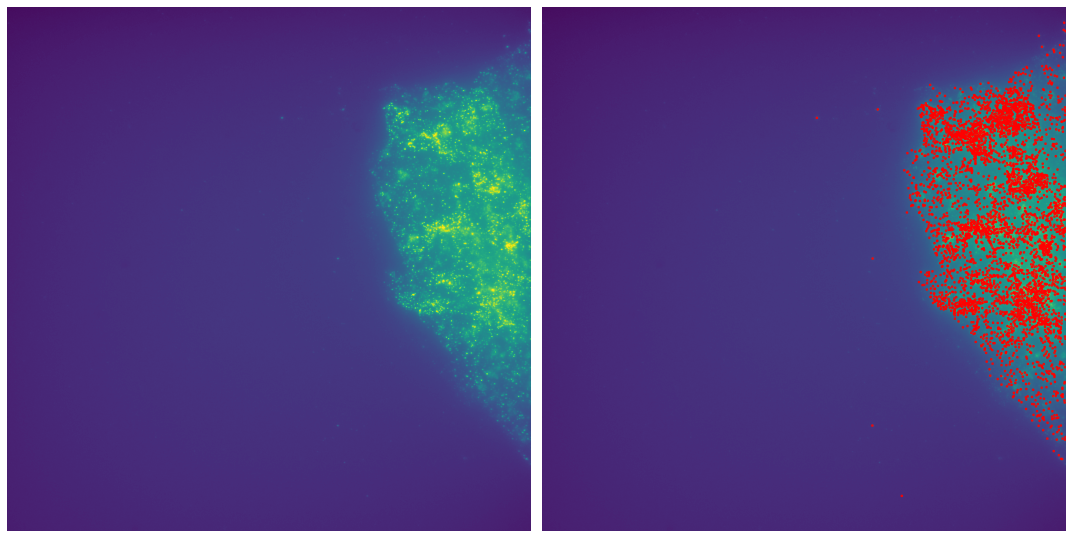

In [70]:
plot.plot_detection(rna_mip, spots, contrast=True)

smfish channel (crop)
 shape: (51, 250, 200)
 dtype: uint16 



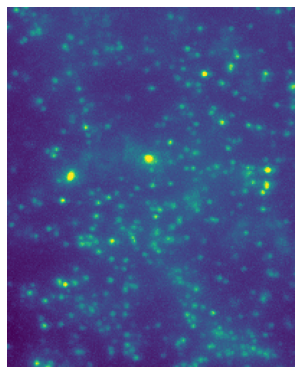

In [63]:
# crop
crop = rna_3d_stretched[:, 1000:1250, 1800:2000]
crop_mip = rna_mip[1000:1250, 1800:2000]
print("smfish channel (crop)")
print("\r shape: {0}".format(crop.shape))
print("\r dtype: {0}".format(crop.dtype), "\n")

# plot
plot.plot_images(crop_mip, contrast=True, framesize=(5, 5))

In [77]:
# pixel fitting
spots_crop = detection.detect_spots(
    images=crop,
    threshold=355.0,  # previous threshold automatically find in the full image
    voxel_size=(300, 103, 103), #nanometers
    spot_radius=(350, 150, 150)) #nanometers
print("spots (pixel fitting)")
print("\r shape: {0}".format(spots_crop.shape))
print("\r dtype: {0}".format(spots_crop.dtype), "\n")

# subpixel fitting
spots_subpixel_crop = detection.fit_subpixel(
    image=crop, 
    spots=spots_crop, 
    voxel_size=(300, 103, 103), 
    spot_radius=(350, 150, 150))
print("spots (subpixel fitting)")
print("\r shape: {0}".format(spots_subpixel_crop.shape))
print("\r dtype: {0}".format(spots_subpixel_crop.dtype))

spots (pixel fitting)
 shape: (9302, 3)
 dtype: int64 

spots (subpixel fitting)
 shape: (9302, 3)
 dtype: float64


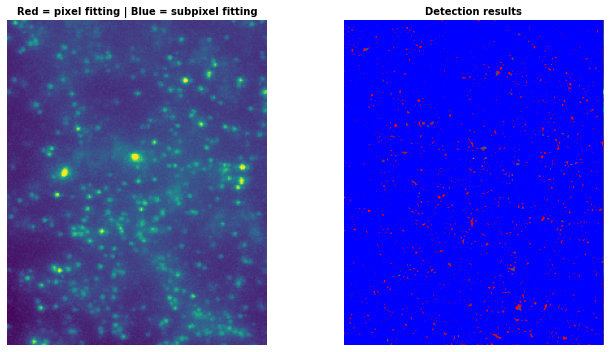

In [78]:
# plot
plot.plot_detection(
    crop_mip, 
    spots=[spots_crop, spots_subpixel_crop], 
    radius=2, 
    color=["red", "blue"],
    title="Red = pixel fitting | Blue = subpixel fitting",
    linewidth=2, contrast=True, framesize=(10, 5))


In [74]:
## save segmentation 
out=spots.astype(np.uint8)
out[out>0]=255

imsave("TOP2A_000_002_spotdetect.tiff", out) 

In [75]:
rna_mip.shape

(2048, 2048)